# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [2]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [3]:
bbc.sample(5)

,category,text
1957,sport,roddick in talks over new coach andy roddick i...
1240,tech,gadget growth fuels eco concerns technology fi...
478,entertainment,rap feud in 50 cent s g-unit crew us rap star ...
132,sport,wales get williams fitness boost wales are hop...
927,sport,wilkinson to lead england fly-half jonny wilki...


In [4]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


### EDA & Data transformation

In [5]:
# Your code here
from sklearn.model_selection import train_test_split

train, test = train_test_split(bbc, test_size=0.2)

In [6]:
print("total record:", len(bbc.index))

total record: 2225


<AxesSubplot:xlabel='category', ylabel='count'>

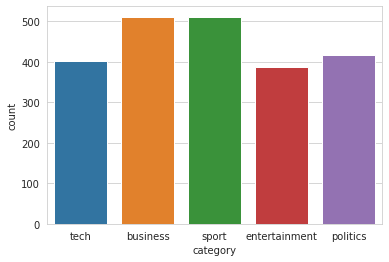

In [7]:
sns.countplot(bbc["category"])

In [8]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()

def tokenizer_porter(text):
  return [porter.stem(word) for word in text.split()]

In [9]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/minhieu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import re
def remove_non_word(text):
   emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
   text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
   return text

### Train models

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=stop,
                        tokenizer=tokenizer_porter,
                        preprocessor=remove_non_word)

In [12]:
bbc["text"]

0       tv future in the hands of viewers with home th...
1       worldcom boss  left books alone  former worldc...
2       tigers wary of farrell  gamble  leicester say ...
3       yeading face newcastle in fa cup premiership s...
4       ocean s twelve raids box office ocean s twelve...
                              ...                        
2220    cars pull down us retail figures us retail sal...
2221    kilroy unveils immigration policy ex-chatshow ...
2222    rem announce new glasgow concert us band rem h...
2223    how political squabbles snowball it s become c...
2224    souness delight at euro progress boss graeme s...
Name: text, Length: 2225, dtype: object

In [13]:
logistic  = LogisticRegression(random_state=0)

In [14]:
pipeline = Pipeline(steps=[('vect', tfidf),
                ('logistic', logistic)])
pipeline.fit(train["text"], train["category"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(preprocessor=<function remove_non_word at 0x7f2831503a60>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function tokenizer_porter at 0x7f28341c5550>)),
                ('logistic', LogisticRegression(random_state=0))])

In [15]:
p_predict = pipeline.predict_proba(test["text"])
f_predict = pipeline.predict(test["text"])
p_predict = pd.DataFrame(p_predict).reindex().rename(columns={0: "business",1: "entertainment",2: "politics",3: "sport",4: "tech"}, errors="raise")
f_predict = pd.DataFrame(f_predict).rename(columns={0: "Predict"}, errors="raise")
predict = pd.concat([test["text"].reset_index(), test["category"].reset_index(),f_predict.reindex(),p_predict], axis=1)
predict.drop("index", axis=1)

,text,category,Predict,business,entertainment,politics,sport,tech
0,us interest rates increased to 2% us interest ...,business,business,0.961442,0.007894,0.009090,0.011239,0.010334
1,howard and blair tax pledge clash tony blair h...,politics,politics,0.008783,0.002792,0.983496,0.002484,0.002445
2,soros group warns of kazakh close the open soc...,business,business,0.373509,0.148785,0.242338,0.116593,0.118774
3,blair defends terror law changes the prime min...,politics,politics,0.006823,0.006192,0.971711,0.005703,0.009571
4,rings of steel combat net attacks gambling is ...,tech,tech,0.048929,0.029801,0.069884,0.028032,0.823354
...,...,...,...,...,...,...,...,...
440,howard attacks pay later budget tory leader ...,politics,politics,0.022572,0.008461,0.953388,0.006511,0.009068
441,us insurer marsh cuts 2 500 jobs up to 2 500 j...,business,business,0.908349,0.021093,0.027764,0.019722,0.023072
442,safin relieved at aussie recovery marat safin ...,sport,sport,0.022502,0.026503,0.016351,0.907125,0.027519
443,moya emotional at davis cup win carlos moya de...,sport,sport,0.018405,0.035914,0.019324,0.904824,0.021533


### Evaluate Model

In [16]:
# Using Test dataset to evaluate model
# classification_report
# confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Now apply those above metrics to evaluate your model
# Your code here
predictions = pipeline.predict(test["text"])
print('accuracy:',accuracy_score(test["category"],predictions))
print('confusion matrix:\n',confusion_matrix(test["category"],predictions))
print('classification report:\n',classification_report(test["category"],predictions))

accuracy: 0.9820224719101124
confusion matrix:
 [[107   0   5   0   0]
 [  0  68   0   0   0]
 [  1   1  75   1   0]
 [  0   0   0 106   0]
 [  0   0   0   0  81]]
classification report:
                precision    recall  f1-score   support

     business       0.99      0.96      0.97       112
entertainment       0.99      1.00      0.99        68
     politics       0.94      0.96      0.95        78
        sport       0.99      1.00      1.00       106
         tech       1.00      1.00      1.00        81

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



### Fine-tunning

In [17]:
from sklearn.model_selection import GridSearchCV
parameters = {'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'logistic__penalty':['l2', 'l1', 'elasticnet']}

gridsearch_models = GridSearchCV(pipeline,
                                 parameters,
                                 scoring='accuracy',
                                 cv=5, n_jobs=-1)

gridsearch_models.fit(train["text"], train["category"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(preprocessor=<function remove_non_word at 0x7f2831503a60>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                        

In [18]:
print('Best params', gridsearch_models.best_params_)
print('Best score', gridsearch_models.best_score_)

Best params {'logistic__C': 10, 'logistic__penalty': 'l2'}
Best score 0.9775280898876403


In [19]:
best_model = gridsearch_models.best_estimator_

In [20]:
p_predict = best_model.predict_proba(test["text"])
f_predict = best_model.predict(test["text"])
p_predict = pd.DataFrame(p_predict).reindex().rename(columns={0: "business",1: "entertainment",2: "politics",3: "sport",4: "tech"}, errors="raise")
f_predict = pd.DataFrame(f_predict).rename(columns={0: "Predict"}, errors="raise")
predict = pd.concat([test["text"].reset_index(), test["category"].reset_index(),f_predict.reindex(),p_predict], axis=1)
predict.drop("index", axis=1)

,text,category,Predict,business,entertainment,politics,sport,tech
0,us interest rates increased to 2% us interest ...,business,business,0.998307,0.000321,0.000337,0.000549,0.000486
1,howard and blair tax pledge clash tony blair h...,politics,politics,0.000448,0.000079,0.999348,0.000063,0.000063
2,soros group warns of kazakh close the open soc...,business,business,0.521761,0.112962,0.229550,0.064475,0.071252
3,blair defends terror law changes the prime min...,politics,politics,0.000175,0.000214,0.999008,0.000159,0.000444
4,rings of steel combat net attacks gambling is ...,tech,tech,0.005688,0.002775,0.015050,0.002258,0.974228
...,...,...,...,...,...,...,...,...
440,howard attacks pay later budget tory leader ...,politics,politics,0.002617,0.000604,0.995768,0.000344,0.000668
441,us insurer marsh cuts 2 500 jobs up to 2 500 j...,business,business,0.993815,0.001264,0.002196,0.001087,0.001638
442,safin relieved at aussie recovery marat safin ...,sport,sport,0.001700,0.002701,0.001383,0.990834,0.003381
443,moya emotional at davis cup win carlos moya de...,sport,sport,0.001189,0.004047,0.001765,0.990957,0.002042


In [21]:
predictions = best_model.predict(test["text"])
print('Accuracy Score:', accuracy_score(test["category"], predictions))

Accuracy Score: 0.9820224719101124


### Export models


In [22]:
import pickle

pickle.dump(best_model, open('logisticRegression.pkl', 'wb'))

In [23]:
with open('logisticRegression.pkl', 'rb') as model:
    reload_model = pickle.load(model)
preds = reload_model.predict_proba(test["text"])

p_predict = pipeline.predict_proba(test["text"])
f_predict = pipeline.predict(test["text"])
p_predict = pd.DataFrame(p_predict).reindex().rename(columns={0: "business",1: "entertainment",2: "politics",3: "sport",4: "tech"}, errors="raise")
f_predict = pd.DataFrame(f_predict).rename(columns={0: "Predict"}, errors="raise")
predict = pd.concat([test["text"].reset_index(), test["category"].reset_index(),f_predict.reindex(),p_predict], axis=1)
predict.drop("index", axis=1)

,text,category,Predict,business,entertainment,politics,sport,tech
0,us interest rates increased to 2% us interest ...,business,business,0.961442,0.007894,0.009090,0.011239,0.010334
1,howard and blair tax pledge clash tony blair h...,politics,politics,0.008783,0.002792,0.983496,0.002484,0.002445
2,soros group warns of kazakh close the open soc...,business,business,0.373509,0.148785,0.242338,0.116593,0.118774
3,blair defends terror law changes the prime min...,politics,politics,0.006823,0.006192,0.971711,0.005703,0.009571
4,rings of steel combat net attacks gambling is ...,tech,tech,0.048929,0.029801,0.069884,0.028032,0.823354
...,...,...,...,...,...,...,...,...
440,howard attacks pay later budget tory leader ...,politics,politics,0.022572,0.008461,0.953388,0.006511,0.009068
441,us insurer marsh cuts 2 500 jobs up to 2 500 j...,business,business,0.908349,0.021093,0.027764,0.019722,0.023072
442,safin relieved at aussie recovery marat safin ...,sport,sport,0.022502,0.026503,0.016351,0.907125,0.027519
443,moya emotional at davis cup win carlos moya de...,sport,sport,0.018405,0.035914,0.019324,0.904824,0.021533
